In [77]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.feature import corner_harris, corner_peaks

Define Functions

In [78]:
def isSegment(p1,p2, bin_im, ksize, sample_num, pvote, cvote):
    x1, y1 = p1
    x2, y2 = p2
    
    x1, x2, y1, y2 = int(x1), int(x2), int(y1), int(y2)
    
    x_disp = abs(x2 - x1)
    y_disp = abs(y2 - y1)
    
    x_step = x_disp / (sample_num + 1)
    y_step = y_disp / (sample_num + 1)
    
    vote = 0
    
    xstart = 0
    ystart = 0
    if x2 >= x1:
        xstart = x1
        ystart = y1
        if y2 < y1:
            y_step = -y_step
    else:
        xstart = x2
        ystart = y2
        if y2 > y1:
            y_step = -y_step
        
    

    for mult in range(1, sample_num + 1):  
        xc, yc = int(xstart + mult*x_step), int(ystart + mult*y_step)
        view = bin_im[xc - ksize: xc + ksize, yc - ksize: yc + ksize]
         
        color = (0,255,0)
        if np.sum(view) >= pvote:
            vote += 1 
            color = (0,0,255)
#             print "OUTPUT" + str(np.sum(view)) + " " + str(pvote)
#         cv2.circle(im_display, (int(xc), int(yc)), ksize, color, thickness=1, lineType=8, shift=0) 

#     print("OUTPUT",vote, cvote)
    return vote >= cvote

In [79]:
def getCorners(img):   
    gray = np.float32(img)
    dst = cv2.cornerHarris(gray,2,3,0.04)
    ret, dst = cv2.threshold(dst,0.1*dst.max(),255,0)
    dst = np.uint8(dst)
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
    dst = cv2.dilate(dst,None)

    return corners

In [80]:
def getSegments(img, corners, ksize, sample_num, pvote, cvote):
    segments = []

    for i in range(len(corners)):
        for j in range(len(corners)):
            if(i != j):
                c1, c2 = corners[i], corners[j]
                print "START PAIR---------------------------------"
                print c1
                print c2
                print "END PAIR ----------------------------------"
                if isSegment(c1, c2, img, ksize, sample_num, pvote, cvote):
                    segments.append((tuple(c1), tuple(c2)))

    return segments


## Test Functions

##### hyperparameters

In [93]:
KSIZE = 3
PVOTE = 7
CVOTE = 18
SAMPLE_NUM = 25

img_directory = "images/"

##### test script

12858


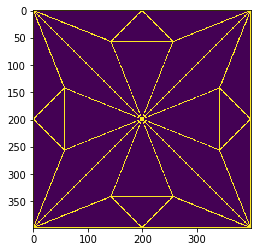

In [94]:
im = cv2.imread(img_directory + "frog.png")
im_display = np.zeros(im.shape, dtype = np.uint8)
im_display.fill(255)
# im_display = im.copy()
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im_orig = im.copy()

# "Preps Image to be displayed" - Lillian

im = np.invert(im)

im[im > 10] = 1
im[im != 1] = 0
plt.imshow(im)

print(np.sum(im))


In [95]:
# corners = getCorners(im_orig)
corners = corner_peaks(corner_harris(im_orig, k=0.2))
segments = getSegments(im, corners, ksize = KSIZE, sample_num = SAMPLE_NUM, pvote = PVOTE, cvote = CVOTE)

for c in corners:
    print c
# print("DETECTED SEGMENTS")
for i in segments:
    cv2.line(im_display, i[0], i[1], (0,0,255),1) 

# # cv2.line(im_display, segments[1][0], segments[1][1], (0,255,0), 3)

# cv2.line(im_display, segments[1][0], segments[1][1], (0,255,0), 3)

    # print("("+ str(i) +","+str(segments.get(i))+")")

# cv2.circle(im_display, (int(196.46725), int(197.349)), 2, (0,255,0), thickness=1, lineType=8, shift=0) 
# test = isSegment((395.45193, 2),(340.5281, 256.2259), im, ksize = KSIZE, sample_num = SAMPLE_NUM, pvote = PVOTE, cvote = CVOTE)
# test = isSegment((395.45193, 200),(340.5281, 256.2259), im, ksize = KSIZE, sample_num = SAMPLE_NUM, pvote = PVOTE, cvote = CVOTE)
# #print test

cv2.imwrite(img_directory + "cornersdisplay" + str(KSIZE) +  str(PVOTE) + str(CVOTE) + str(SAMPLE_NUM) + ".png", im_display)


START PAIR---------------------------------
[  3 197]
[  3 199]
END PAIR ----------------------------------
START PAIR---------------------------------
[  3 197]
[  3 201]
END PAIR ----------------------------------
START PAIR---------------------------------
[  3 197]
[4 4]
END PAIR ----------------------------------
START PAIR---------------------------------
[  3 197]
[  4 394]
END PAIR ----------------------------------
START PAIR---------------------------------
[  3 197]
[ 56 145]
END PAIR ----------------------------------
START PAIR---------------------------------
[  3 197]
[ 56 253]
END PAIR ----------------------------------
START PAIR---------------------------------
[  3 197]
[ 57 198]
END PAIR ----------------------------------
START PAIR---------------------------------
[  3 197]
[ 57 200]
END PAIR ----------------------------------
START PAIR---------------------------------
[  3 197]
[ 58 143]
END PAIR ----------------------------------
START PAIR----------------------

START PAIR---------------------------------
[ 58 143]
[200  57]
END PAIR ----------------------------------
START PAIR---------------------------------
[ 58 143]
[200 341]
END PAIR ----------------------------------
START PAIR---------------------------------
[ 58 143]
[201   3]
END PAIR ----------------------------------
START PAIR---------------------------------
[ 58 143]
[201 395]
END PAIR ----------------------------------
START PAIR---------------------------------
[ 58 143]
[253  56]
END PAIR ----------------------------------
START PAIR---------------------------------
[ 58 143]
[253  59]
END PAIR ----------------------------------
START PAIR---------------------------------
[ 58 143]
[253 339]
END PAIR ----------------------------------
START PAIR---------------------------------
[ 58 143]
[253 342]
END PAIR ----------------------------------
START PAIR---------------------------------
[ 58 143]
[255  58]
END PAIR ----------------------------------
START PAIR------------------

END PAIR ----------------------------------
START PAIR---------------------------------
[145 342]
[ 57 198]
END PAIR ----------------------------------
START PAIR---------------------------------
[145 342]
[ 57 200]
END PAIR ----------------------------------
START PAIR---------------------------------
[145 342]
[ 58 143]
END PAIR ----------------------------------
START PAIR---------------------------------
[145 342]
[ 58 255]
END PAIR ----------------------------------
START PAIR---------------------------------
[145 342]
[ 59 145]
END PAIR ----------------------------------
START PAIR---------------------------------
[145 342]
[ 59 253]
END PAIR ----------------------------------
START PAIR---------------------------------
[145 342]
[143  58]
END PAIR ----------------------------------
START PAIR---------------------------------
[145 342]
[143 340]
END PAIR ----------------------------------
START PAIR---------------------------------
[145 342]
[145  56]
END PAIR -------------------

[201   3]
[198  57]
END PAIR ----------------------------------
START PAIR---------------------------------
[201   3]
[198 341]
END PAIR ----------------------------------
START PAIR---------------------------------
[201   3]
[199   3]
END PAIR ----------------------------------
START PAIR---------------------------------
[201   3]
[199 395]
END PAIR ----------------------------------
START PAIR---------------------------------
[201   3]
[200  57]
END PAIR ----------------------------------
START PAIR---------------------------------
[201   3]
[200 341]
END PAIR ----------------------------------
START PAIR---------------------------------
[201   3]
[201 395]
END PAIR ----------------------------------
START PAIR---------------------------------
[201   3]
[253  56]
END PAIR ----------------------------------
START PAIR---------------------------------
[201   3]
[253  59]
END PAIR ----------------------------------
START PAIR---------------------------------
[201   3]
[253 339]
END PAIR

[199 395]
END PAIR ----------------------------------
START PAIR---------------------------------
[340 143]
[200  57]
END PAIR ----------------------------------
START PAIR---------------------------------
[340 143]
[200 341]
END PAIR ----------------------------------
START PAIR---------------------------------
[340 143]
[201   3]
END PAIR ----------------------------------
START PAIR---------------------------------
[340 143]
[201 395]
END PAIR ----------------------------------
START PAIR---------------------------------
[340 143]
[253  56]
END PAIR ----------------------------------
START PAIR---------------------------------
[340 143]
[253  59]
END PAIR ----------------------------------
START PAIR---------------------------------
[340 143]
[253 339]
END PAIR ----------------------------------
START PAIR---------------------------------
[340 143]
[253 342]
END PAIR ----------------------------------
START PAIR---------------------------------
[340 143]
[255  58]
END PAIR ---------

[394 394]
END PAIR ----------------------------------
START PAIR---------------------------------
[395 201]
[395 197]
END PAIR ----------------------------------
START PAIR---------------------------------
[395 201]
[395 199]
END PAIR ----------------------------------
[  3 197]
[  3 199]
[  3 201]
[4 4]
[  4 394]
[ 56 145]
[ 56 253]
[ 57 198]
[ 57 200]
[ 58 143]
[ 58 255]
[ 59 145]
[ 59 253]
[143  58]
[143 340]
[145  56]
[145  59]
[145 339]
[145 342]
[197   3]
[197 395]
[198  57]
[198 341]
[199   3]
[199 395]
[200  57]
[200 341]
[201   3]
[201 395]
[253  56]
[253  59]
[253 339]
[253 342]
[255  58]
[255 340]
[339 145]
[339 253]
[340 143]
[340 255]
[341 198]
[341 200]
[342 145]
[342 253]
[394   4]
[394 394]
[395 197]
[395 199]
[395 201]


True